<a href="https://colab.research.google.com/github/EnochYounceSAIC/colab/blob/main/weekone/Left_to_Right_EDFA_attenuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [49]:
length = 3000
span = 100
#Fiber type: SMF-28
#current task: model EDFA noise and amplification
EDFA_noise = 4.7 #dB
EDFA_gain = 17 #dBm
#fiber data sheet used : https://www.corning.com/media/worldwide/coc/documents/Fiber/product-information-sheets/PI-1470-AEN.pdf
#EDFA used EDFA 100s : https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_ID=10680
#single wavelength light, using 1550nm
lambda_light = 1550e-9
f_light = 3e8/lambda_light
#using max attenuation as a graph or standard deviation is not provided
attenuation = 0.17 #dB/km
power_initial = 3 #dBm

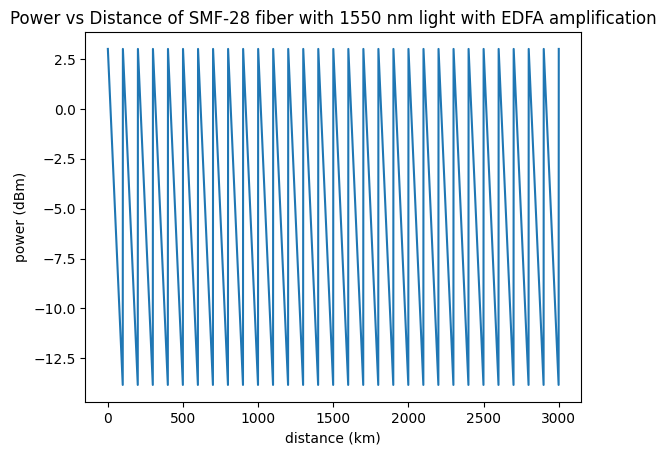

In [50]:
distance = np.arange(0,length+1,1) #+1 to put an amplifier at the endpoint as would be done to read the signal
# Calculate power in mW
# Power starts at initial power, attenuates, and gets a discrete gain at each amplifier location starting from 100 km
power_mW = np.zeros(length+1)
power_mW[0] = 10**(power_initial/10) # Initial power in mW

for i in range(1, length+1):
    # Power at current point is power at previous point minus attenuation over 1 km
    power_mW[i] = power_mW[i-1] * 10**(-attenuation / 10)
    # Add EDFA gain at amplifier locations (at span, 2*span, 3*span, etc.)
    if i > 0 and i % span == 0:
        power_mW[i] *= 10**(EDFA_gain/10)


# Convert power back to dBm for potential uses later
power_dBm = 10 * np.log10(power_mW)

plt.plot(distance,power_dBm)
plt.xlabel('distance (km)')
plt.ylabel('power (dBm)')
plt.title('Power vs Distance of SMF-28 fiber with 1550 nm light with EDFA amplification')
plt.show()

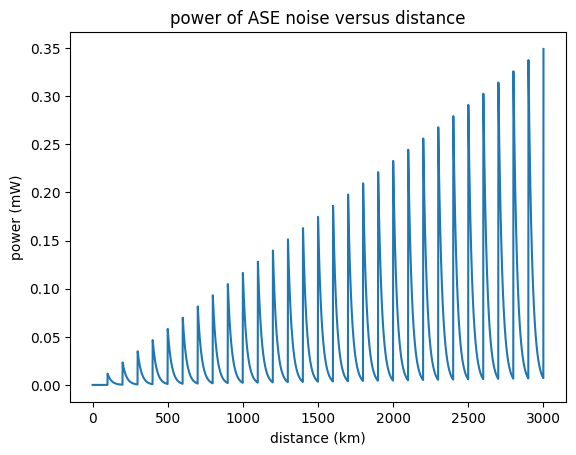

In [51]:
#noise calculations
planks_const = 6.626e-34 #J*s
bandwidth_nm = 0.1e-9 #0.1nm
# Convert bandwidth from nm to frequency (Hz)
bandwidth_freq = bandwidth_nm * (f_light / lambda_light)

# Convert EDFA noise figure from dB to linear
EDFA_noise_linear = 10**(EDFA_noise/10)
power_ase_per_amp = planks_const * f_light * EDFA_noise_linear * (10**(EDFA_gain/10) - 1) * bandwidth_freq # J/s or Watts (W)

# Convert power_ase_per_amp from Watts to mW
power_ase_per_amp_mW = power_ase_per_amp * 1000

#graph
ASE_noise = np.zeros(length+1)
for i in range(100,length+1):
  ASE_noise[i] = ASE_noise[i-1]*1/(10**(attenuation/10))
  if(i%100 ==0):
      ASE_noise[i] += power_ase_per_amp_mW
      ASE_noise[i] *= 10**(EDFA_gain/10)


plt.plot(distance,ASE_noise)
plt.xlabel('distance (km)')
plt.ylabel('power (mW)')
plt.title("power of ASE noise versus distance")
plt.show()

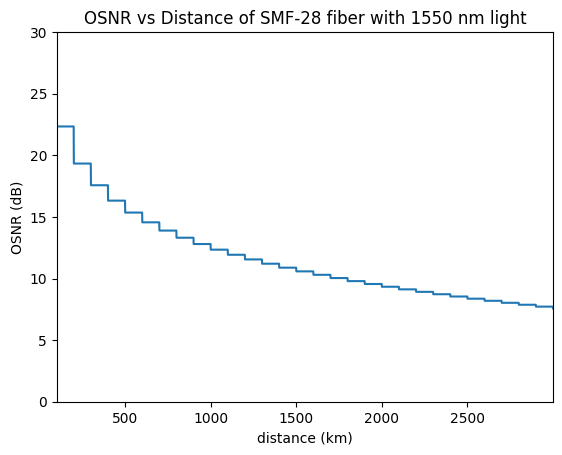

In [56]:
# Add a small epsilon to noise to avoid division by zero and log of zero/negative
noise_plus_epsilon = ASE_noise + np.finfo(float).eps

OSNR = 10*np.log10(power_mW/noise_plus_epsilon)

plt.plot(distance,OSNR)
plt.xlabel('distance (km)')
plt.ylabel('OSNR (dB)')
plt.xlim(101,2999)
plt.ylim(0,30)
plt.title('OSNR vs Distance of SMF-28 fiber with 1550 nm light')
plt.show()

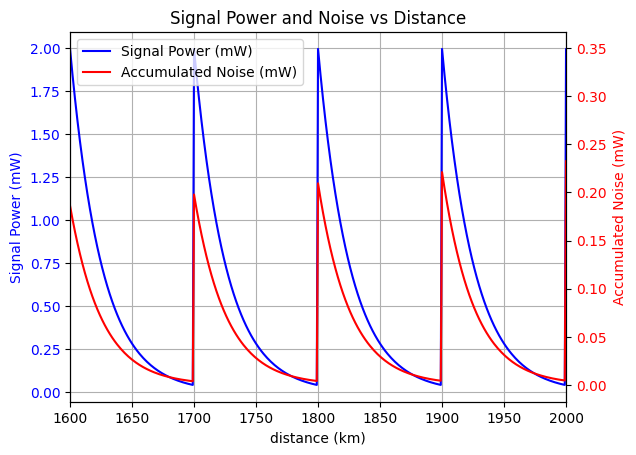

In [53]:
# Plot power_mW and noise_plus_epsilon on the same graph
fig, ax1 = plt.subplots()

ax1.plot(distance, power_mW, label='Signal Power (mW)', color='blue')
ax1.set_xlabel('distance (km)')
ax1.set_ylabel('Signal Power (mW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Signal Power and Noise vs Distance')
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(distance, noise_plus_epsilon, label='Accumulated Noise (mW)', color='red')
ax2.set_ylabel('Accumulated Noise (mW)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.xlim(1600,2000)
plt.show()

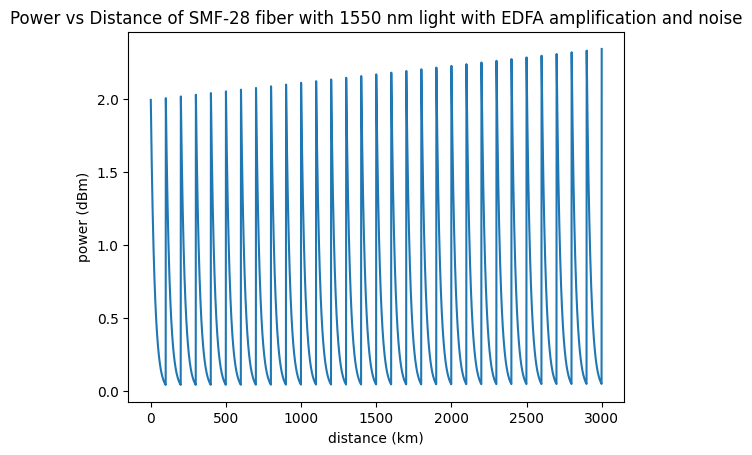

In [54]:
full_output = power_mW + ASE_noise
plt.plot(distance,full_output)
plt.xlabel('distance (km)')
plt.ylabel('power (dBm)')
plt.title('Power vs Distance of SMF-28 fiber with 1550 nm light with EDFA amplification and noise')
plt.show()